In [14]:
import numpy as np
import healpy as hp
import os,sys
import matplotlib.pyplot as plt
import curvedsky

import lenspyx

In [2]:
def bl(fwhm, lmax=None, nside=None, pixwin=True):    #bl包括相当于beam window function 和 pixel window function,相当于e^-(l(l+1)* \sigma^2)(这是beam window function)
    """ Transfer function.

        * fwhm      : beam fwhm in arcmin
        * lmax      : lmax
        * pixwin    : whether include pixwin in beam transfer function
        * nside     : nside
    """
    assert lmax or nside
    lmax = min( 3 * nside - 1, lmax ) if nside and lmax else lmax if lmax else 3*nside - 1
    ret = hp.gauss_beam(fwhm * np.pi / 60. / 180., lmax=lmax)   #return: beam window function
    if pixwin:
        assert nside is not None
        ret *= hp.pixwin(nside, lmax=lmax)      #hp.pixwin: Return the pixel window function for the given nside
    return ret


def bl_eft(nrms_f, fwhm_f, lmax=None, pixwin=True, ret_nlev=False):  #bl_eft 包括noise_level、beam window function 和 pixel window function,即bl乘了(\Delta_t/p)^2
    """ Effective beam.
    """
    nrms_f = [ hp.read_map(nrms) if isinstance(nrms, str) else nrms for nrms in nrms_f ] #variance map 里存的不是variance,而是standard deviation(标准差)
    nside = hp.npix2nside(len(nrms_f[0]))

    nlev_f = np.array([ uKpix2uKamin(np.mean(nrms[nrms > 0] ** -2) ** -0.5 ,     #非mask区域对应的nrms(N功率谱方均根),对应1/(nlev)^2 = np.mean(1/(nrms)^2)                                                    
                        hp.nside2npix(nside)) for nrms in nrms_f]) # in uK.radians  #这里np.mean(nrms[nrms > 0] ** -2) ** -0.5是对高斯分布求平均(先平方避免正负相消)的算法，建议使用之前画出nrms的直方图(纵轴即个数)，看看是否符合高斯分布
    nlev = sum(nlev_f ** -2) ** -0.5 # in uk.arcmin
    bl_f = [ bl(fwhm, pixwin=pixwin, lmax=lmax, nside=nside) for fwhm in fwhm_f ]
    bl_eft = (sum([ nlev ** -2 * bl ** 2 for nlev, bl in zip(nlev_f, bl_f) ])
                * nlev ** 2) ** 0.5
    
    
    if ret_nlev:
        return nlev, bl_eft  #返回noiselevel和Effective beam
    else:
        return bl_eft        #仅返回Effective beam

In [ ]:
def lensed_cmbs(cls, nside, savePath, lenspyx_geom, fwhm_f=[], nrms_f=None, lmax=4096, dlmax=1024, facres=-1, seed=0, pixwin=True):
    """ Lensed CMB TQU maps random realiazation.

         * cls      : dict which contiains input power spectra
         * nside    : nside
         * savePath : directory where you store the simulations
         * lmax     : max ell
         * dlmax    : dmax ell
         * fwhm     : Full Width Half Maximum (Beam size)
         * seed     : array which contains random seed
    """
    assert 'OMP_NUM_THREADS' in os.environ.keys(), 'Check your env variable OMP_NUM_THREADS' #OMP_NUM_THREADS用于控制并行计算库（例如OpenMP）的线程数量，在.bashrc中加入export OMP_NUM_THREADS=4

    fname_TQU = 'map_TQU_%d_%04d.fits'
    fname_P = 'map_P_%d_%04d.fits'
    
    # Lensed maps realization. Correlations between PTE not considered.
    # transfer function NOTE pixwin func is included as well
    if len(fwhm_f) == 0 or 1:
        fwhm_f = fwhm_f[0] if fwhm_f else 0.
        transf = bl(fwhm_f, nside=nside, lmax=lmax, pixwin=pixwin)
    else:
        assert nrms_f
        transf = bl_eft(nrms_f, fwhm_f, nside=nside, lmax=lmax, pixwin=pixwin)  #Effective beam function

    np.random.seed(seed)  
    #seed 用于初始化 NumPy 随机数生成器，当设置了相同的 seed 值时，np.random 将使用相同的初始状态来生成随机数序列，这生成相同的随机数。通过更改 seed 值，可以创建不同的随机数序列，例见1.ipynb

    # Unlensed TQUP alms
    plm = hp.synalm(cls['pp'], lmax=lmax + dlmax, new=True, verbose=False)
    Pmap = hp.alm2map(plm, nside, verbose=False)
    dlm = hp.almxfl(plm, np.sqrt(np.arange(lmax + 1, dtype=float) * np.arange(1, lmax + 2)))
    tlm_unl, elm_unl, blm_unl = hp.synalm(  [cls['tt'], cls['ee'], cls['bb'], cls['te']], lmax=lmax + dlmax, new=True, verbose=False)
    # NOTE we only consider lensing induced E->B modes
    
    if lenspyx_geom == 'healpix':
        geom_info = ('healpix', {'nside':nside})
        Tlen = lenspyx.lensing.alm2lenmap(tlm_unl, dlm,  geometry=geom_info, verbose=False)#alm2lenmap：alm_unl * dlm -> lensed map
        Qlen, Ulen = lenspyx.lensing.alm2lenmap_spin(elm_unl, dlm, 2, geometry=geom_info, verbose=False)
    elif lenspyx_geom == 'thingauss':
        from lenspyx.remapping import deflection_029
        from lenspyx.remapping import utils_geom
        len_geom = utils_geom.Geom.get_thingauss_geometry(lmax+dlmax, 2)
        bdGeom = utils_geom.pbdGeometry(len_geom, utils_geom.pbounds(np.pi, 2 * np.pi))

        ffi = deflection_029.deflection(len_geom, dlm, dlmax, numthreads=4, dclm=None)
        len_tlm = ffi.lensgclm(tlm_unl.astype(np.complex64).T, None, 0, lmax, lmax)
        len_elm, len_blm = ffi.lensgclm(np.array([elm_unl.astype(np.complex64).T, blm_unl.astype(np.complex64).T]), None, 2, lmax, lmax)
        
        #### convert alm to map using cmblensplus
        len_tlm_pix = curvedsky.utils.lm_healpy2healpix(len_tlm, lmax, lmpy=0)
        len_elm_pix = curvedsky.utils.lm_healpy2healpix(len_elm, lmax, lmpy=0)
        len_blm_pix = curvedsky.utils.lm_healpy2healpix(len_blm, lmax, lmpy=0)
        Tlen = curvedsky.utils.hp_alm2map(nside, lmax, lmax, len_tlm_pix)
        Qlen, Ulen = curvedsky.utils.hp_alm2map_spin(nside, lmax, lmax, 2, len_elm_pix, len_blm_pix)

        """#### convert alm to map using healpy
        len_tlm = len_tlm.astype(np.complex128)   #### This will increase the variance of the lensed power at large scales
        len_elm = len_elm.astype(np.complex128)
        len_blm = len_blm.astype(np.complex128)
        Tlen, Qlen, Ulen = hp.alm2map([len_tlm, len_elm, len_blm], nside, lmax)   #### This is not correct
        """


    '''
    this is the original code, but it is not suitable for the new version of lenspyx, it is suitable for lenspyx 2.0.0
    Tlen = lenspyx.alm2lenmap(tlm_unl, [dlm, None], nside, facres=facres, verbose=False)
    Qlen, Ulen = lenspyx.alm2lenmap_spin([elm_unl, None], [dlm, None], nside, 2, geometry=geom_info, verbose=False)   #这里QU的spin=2,要用alm2lenmap_spin
    '''
    if fwhm_f:
        tlm_len = hp.map2alm(Tlen, lmax=lmax)
        elm_len, blm_len = hp.map2alm_spin([Qlen, Ulen], 2, lmax=lmax)
        
        # Convolution with transfer function    #tranf = H_l*B_l, 见PLANCK2015 (A.4)，亦见PLANCK2013 (38)式
        Tlen = hp.alm2map(hp.almxfl(tlm_len, transf, inplace=True), nside, verbose=False)
        Qlen, Ulen = hp.alm2map_spin([hp.almxfl(elm_len, transf), hp.almxfl(blm_len, transf)], nside, 2, lmax)

    return Tlen, Qlen, Ulen

In [4]:
def camb_clfile(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls, tensCls or ScalCls types) returned as a dict of numpy arrays.

    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.

    """
    with open(fname) as f:
        firstline = next(f)
    keys = [i.lower() for i in firstline.replace('\n', '').split(' ') if i.isalpha()][1:]
    cols = np.loadtxt(fname).transpose()

    ell = cols[0].astype(np.int64)
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)

    cls = {k : np.zeros(lmax + 1, dtype=float) for k in keys}

    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)

    w = lambda ell :ell * (ell + 1.) / (2. * np.pi)
    wpp = lambda ell : ell ** 2 * (ell + 1.) ** 2 / (2. * np.pi)
    wptpe = lambda ell :np.sqrt(ell.astype(float) ** 3 * (ell + 1.) ** 3) / (2. * np.pi)
    for i, k in enumerate(keys):
        if k == 'pp':
            we = wpp(ell)
        elif 'p' in k and ('e' in k or 't' in k):
            we = wptpe(ell)
        else:
            we = w(ell)
        cls[k][ell[idc]] = cols[i + 1][idc] / we[idc]
    return cls

# CONCLUSION:

## 1） generated lensed field with 'healpix' geometry will be OK in any case

## 2） generated lensed field with 'thingauss' geometry will be accurate as 'alm', but any alm2map conversion from healpy will return the field into an unlensed one. I don't know the reason!!!!!!!!!!!!!
        We instead use the alm2map conversion from cmblensplus.


In [60]:
cls = camb_clfile('/root/download/delensalot/delensalot/data/cls/FFP10_wdipole_lenspotentialCls.dat')
T1,Q1,U1 = lensed_cmbs(cls, 1024, 'savePath', lenspyx_geom = 'healpix', fwhm_f=[], nrms_f=None, lmax=3071, dlmax=3071, facres=-1, seed=0, pixwin=False)

/tmp/ipykernel_25077/2500497468.py:30: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  plm = hp.synalm(cls['pp'], lmax=lmax + dlmax, new=True, verbose=False)
/tmp/ipykernel_25077/2500497468.py:31: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  Pmap = hp.alm2map(plm, nside, verbose=False)
/tmp/ipykernel_25077/2500497468.py:33: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  tlm_unl, elm_unl, blm_unl = hp.synalm(  [cls['tt'], cls['ee'], cls['bb'], cls['te']], lmax=lmax + dlmax, new=True, verbose=False)


In [6]:
T2,Q2,U2 = lensed_cmbs(cls, 1024, 'savePath', lenspyx_geom= 'thingauss',fwhm_f=[], nrms_f=None, lmax=3071, dlmax=3071, facres=-1, seed=0, pixwin=False)

/tmp/ipykernel_25077/2583438982.py:30: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  plm = hp.synalm(cls['pp'], lmax=lmax + dlmax, new=True, verbose=False)
/tmp/ipykernel_25077/2583438982.py:31: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  Pmap = hp.alm2map(plm, nside, verbose=False)
/tmp/ipykernel_25077/2583438982.py:33: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  tlm_unl, elm_unl, blm_unl = hp.synalm(  [cls['tt'], cls['ee'], cls['bb'], cls['te']], lmax=lmax + dlmax, new=True, verbose=False)


In [ ]:
nside = 1024
lmax = 3071
dlmax = 3071

tlm_unl, elm_unl, blm_unl = hp.synalm(  [cls['tt'], cls['ee'], cls['bb'], cls['te']], lmax=lmax, new=True, verbose=False)
plm = hp.synalm(cls['pp'], lmax=dlmax, new=True, verbose=False)
dlm = hp.almxfl(plm, np.sqrt(np.arange(lmax + 1, dtype=float) * np.arange(1, lmax + 2)))


from lenspyx.remapping import deflection_029
from lenspyx.remapping import utils_geom
len_geom = utils_geom.Geom.get_thingauss_geometry(lmax+dlmax, 2)
bdGeom = utils_geom.pbdGeometry(len_geom, utils_geom.pbounds(np.pi, 2 * np.pi))

ffi = deflection_029.deflection(len_geom, dlm, dlmax, numthreads=4, dclm=None)
len_tlm = ffi.lensgclm(tlm_unl.astype(np.complex64).T, None, 0, lmax, lmax)
len_elm, len_blm = ffi.lensgclm(np.array([elm_unl.astype(np.complex64).T, blm_unl.astype(np.complex64).T]), None, 2, lmax, lmax)

#len_tlm = len_tlm.astype(np.complex128)
#len_elm = len_elm.astype(np.complex128)
#len_blm = len_blm.astype(np.complex128)


/tmp/ipykernel_25077/933561881.py:5: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  tlm_unl, elm_unl, blm_unl = hp.synalm(  [cls['tt'], cls['ee'], cls['bb'], cls['te']], lmax=lmax, new=True, verbose=False)
/tmp/ipykernel_25077/933561881.py:6: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  plm = hp.synalm(cls['pp'], lmax=dlmax, new=True, verbose=False)


In [43]:
len_tlm_pix = curvedsky.utils.lm_healpy2healpix(len_tlm, lmax, lmpy=0)
len_elm_pix = curvedsky.utils.lm_healpy2healpix(len_elm, lmax, lmpy=0)
len_blm_pix = curvedsky.utils.lm_healpy2healpix(len_blm, lmax, lmpy=0)

In [44]:
Tlen_pix = curvedsky.utils.hp_alm2map(nside, lmax, lmax, len_tlm_pix)
Qlen_pix, Ulen_pix = curvedsky.utils.hp_alm2map_spin(nside, lmax, lmax, 2, len_elm_pix, len_blm_pix)


In [40]:
cl3 = hp.anafast([Tlen_pix, Qlen_pix, Ulen_pix])

In [45]:
cl4 = hp.anafast([Tlen_pix, Qlen_pix, Ulen_pix])

In [8]:
Tunl, Qunl, Uunl = hp.alm2map([tlm_unl, elm_unl, blm_unl], 1024, lmax)

In [9]:
cltt = hp.alm2cl(len_tlm)
clee = hp.alm2cl(len_elm)
clbb = hp.alm2cl(len_blm)

In [10]:
cl1 = hp.anafast([T1,Q1,U1])
cl2 = hp.anafast([T2,Q2,U2])

In [11]:
l = np.arange(lmax+1)

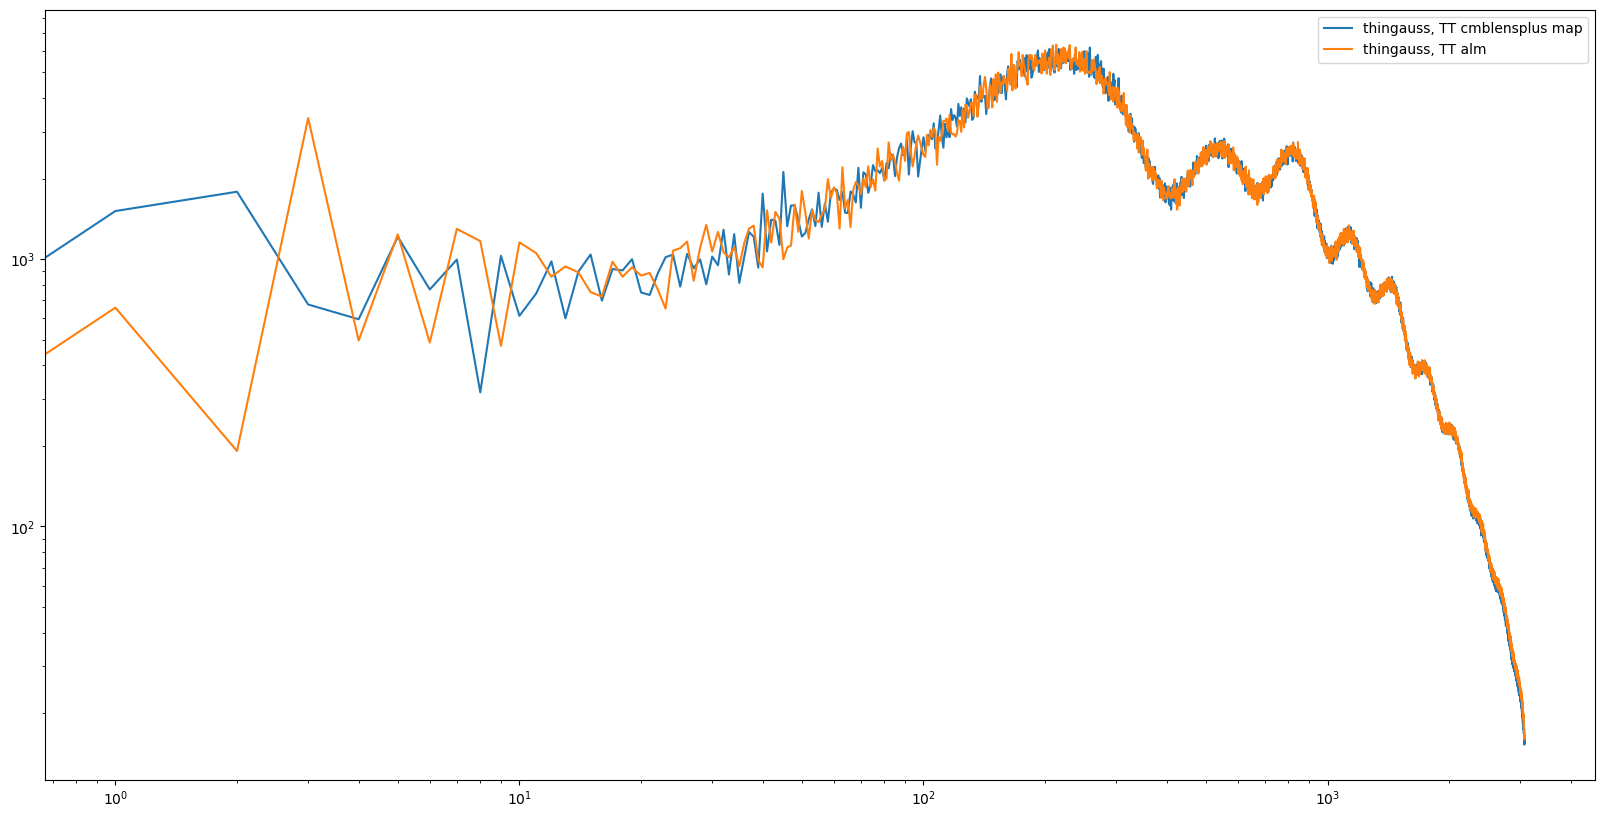

In [53]:
plt.figure(figsize=(20,10))
"""
plt.loglog(cl1[0]*l*(l+1)/(2*np.pi),label='healpix, TT')
plt.loglog(cl1[1]*l*(l+1)/(2*np.pi),label='healpix, EE')
plt.loglog(cl1[2]*l*(l+1)/(2*np.pi),label='healpix, BB')


# !!!!!!!!!!!!!!!!!!!!!!!!!!!! 'thingauss' alm to healpy map, this becomes the unlensed field again!!!!!!!!!!!!!!!!!!!!!!!   
plt.loglog(cl2[0]*l*(l+1)/(2*np.pi),'.',label='thingauss, TT healpy map')
plt.loglog(cl2[1]*l*(l+1)/(2*np.pi),'.',label='thingauss, EE healpy map')
plt.loglog(cl2[2]*l*(l+1)/(2*np.pi),'.',label='thingauss, BB healpy map')     ##########  Obviously, the B field is not the lensed field, this is wrong
"""

# !!!!!!!!!!!!!!!!!!!!!!!!!!!! 'thingauss' alm to cmblensplus map, this becomes the unlensed field again!!!!!!!!!!!!!!!!!!!!!!!   
#plt.loglog(cl3[0]*l*(l+1)/(2*np.pi),label='thingauss, TT cmblensplus map')
#plt.loglog(cl3[1]*l*(l+1)/(2*np.pi),label='thingauss, EE cmblensplus map')
#plt.loglog(cl3[2]*l*(l+1)/(2*np.pi),label='thingauss, BB cmblensplus map')     


# !!!!!!!!!!!!!!!!!!!!!!!!!!!! 'thingauss' alm to cmblensplus map, this becomes the unlensed field again!!!!!!!!!!!!!!!!!!!!!!!   
plt.loglog(cl4[0]*l*(l+1)/(2*np.pi),label='thingauss, TT cmblensplus map')
#plt.loglog(cl4[1]*l*(l+1)/(2*np.pi),label='thingauss, EE cmblensplus map')
#plt.loglog(cl4[2]*l*(l+1)/(2*np.pi),label='thingauss, BB cmblensplus map')  


# !!!!!!!!!!!!!!!!!!!!!!!!!!!! 'thingauss' alm, this seems to be accurate !!!!!!!!!!!!!!!!!!!!!!!
plt.loglog(cltt*l*(l+1)/(2*np.pi),label='thingauss, TT alm')
#plt.loglog(clee*l*(l+1)/(2*np.pi),label='thingauss, EE alm')
#plt.loglog(clbb*l*(l+1)/(2*np.pi),label='thingauss, BB alm')



plt.legend()